#### Prompt Eval

In [ ]:
import mlflow
import pandas as pd
# ไม่ต้อง import make_metric ถ้าไม่ได้ใช้ custom metric
# from mlflow.models import make_metric

# สมมติว่าเรามีโมเดล 2 ตัวที่อยากเปรียบเทียบ
def model_A(inputs):
    # ในการใช้งานจริง inputs ที่เข้ามาจะเป็น pandas DataFrame
    # เราต้องดึงคอลัมน์ที่ต้องการออกมา
    questions = inputs["questions"].tolist()
    return [f"คำตอบจาก Model A สำหรับคำถาม: {q}" for q in questions]

def model_B(inputs):
    questions = inputs["questions"].tolist()
    return [f"คำตอบจาก Model B สำหรับคำถาม: {q}" for q in questions]

# ข้อมูลที่เราจะใช้ทดสอบ
eval_data = pd.DataFrame(
    {
        "questions": [
            "ประวัติของกรุงเทพมหานครคืออะไร?",
            "ใครคือนายกรัฐมนตรีคนปัจจุบันของไทย?",
        ],
        "ground_truth": [ # คำตอบที่ถูกต้อง (ถ้ามี)
            "กรุงเทพมหานครสร้างขึ้นในสมัยรัตนโกสินทร์...",
            "นายกรัฐมนตรีคนปัจจุบันคือคุณเศรษฐา ทวีสิน",
        ],
    }
)

# --- นี่คือส่วนที่แก้ไข ---

# 1. ประเมินผล Model A ใน Run แรก
with mlflow.start_run(run_name="Evaluation for Model A") as run_a:
    print(f"กำลังประเมิน Model A ใน Run ID: {run_a.info.run_id}")
    results_a = mlflow.evaluate(
        model=model_A,  # ใส่แค่ model_A ตัวเดียว
        data=eval_data,
        targets="ground_truth",
        model_type="question-answering",
    )
    print("ผลลัพธ์ของ Model A:")
    print(results_a.metrics)


# 2. ประเมินผล Model B ใน Run ที่สอง
with mlflow.start_run(run_name="Evaluation for Model B") as run_b:
    print(f"กำลังประเมิน Model B ใน Run ID: {run_b.info.run_id}")
    results_b = mlflow.evaluate(
        model=model_B,  # ใส่แค่ model_B ตัวเดียว
        data=eval_data,
        targets="ground_truth",
        model_type="question-answering",
    )
    print("ผลลัพธ์ของ Model B:")
    print(results_b.metrics)
 

2025/06/18 21:23:41 INFO mlflow.models.evaluation.utils.trace: Auto tracing is temporarily enabled during the model evaluation for computing some metrics and debugging. To disable tracing, call `mlflow.autolog(disable=True)`.
2025/06/18 21:23:41 INFO mlflow.models.evaluation.evaluators.default: Computing model predictions.
2025/06/18 21:23:41 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...


กำลังประเมิน Model A ใน Run ID: c9c4b291f6fc4544981609884e4142dd


2025/06/18 21:23:44 WARNING mlflow.metrics.metric_definitions: Failed to load 'toxicity' metric (error: ModuleNotFoundError("No module named 'evaluate'")), skipping metric logging.
2025/06/18 21:23:44 WARNING mlflow.models.evaluation.utils.metric: Did not log metric 'toxicity' at index 1 in the `extra_metrics` parameter because it returned None.
2025/06/18 21:23:44 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for flesch kincaid metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2025/06/18 21:23:44 WARNING mlflow.models.evaluation.utils.metric: Did not log metric 'flesch_kincaid_grade_level' at index 2 in the `extra_metrics` parameter because it returned None.
2025/06/18 21:23:44 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for automated readability index metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2025/06/18 21:23:44 WARNING mlflow.models.evaluation.utils.metri

ผลลัพธ์ของ Model A:
{'exact_match/v1': 0.0}
กำลังประเมิน Model B ใน Run ID: aeee6ad01d554b6995ad6012b2c34190
ผลลัพธ์ของ Model B:
{'exact_match/v1': 0.0}

ประเมินผลเสร็จสิ้น! เปิด MLflow UI เพื่อเปรียบเทียบผลลัพธ์ของ 2 Runs


#### log trace monitor

In [7]:
import mlflow
import openai
from src.utils.app_config import AppConfig
 
cfg = AppConfig.from_files(model_config_path = "configs/model_config.yaml", environment_config_path = "config.yaml")

openai.api_key = cfg.openai_token
# Prompt Template ของเรา
prompt_template = """
คุณคือผู้ช่วย AI ที่เชี่ยวชาญด้านประวัติศาสตร์ไทย
จงตอบคำถามต่อไปนี้ให้กระชับและถูกต้อง:

คำถาม: {question}
"""

def create_response(question, temp):
    prompt = prompt_template.format(question=question)
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=temp,
    )
    return response.choices[0].message.content

# ลองทดลอง 2 แบบ ด้วย temperature ที่ต่างกัน
question = "ใครคือพระมหากษัตริย์องค์แรกแห่งราชวงศ์จักรี?"

# การทดลองที่ 1: Temperature = 0.2
with mlflow.start_run(run_name="Creative Prompt Run"):
    mlflow.log_param("temperature", 0.8) # บันทึก parameter
    mlflow.log_param("prompt_template", prompt_template) # บันทึก template
    answer = create_response(question, temp=0.8)
    mlflow.log_text(answer, artifact_file="model_output.txt") # บันทึกผลลัพธ์

# การทดลองที่ 2: Temperature = 0.8
with mlflow.start_run(run_name="Factual Prompt Run"):
    mlflow.log_param("temperature", 0.2)
    mlflow.log_param("prompt_template", prompt_template)
    answer = create_response(question, temp=0.2)
    mlflow.log_text(answer, artifact_file="model_output.txt")

In [ ]:
# ======= test log_metric =======
# บันทึก "ความคืบหน้า" ของค่าใดค่าหนึ่งที่เปลี่ยนแปลงตลอดเวลา
import mlflow
import time
import random

# จำลองการเทรนโมเดลที่มี 10 epochs
with mlflow.start_run(run_name="Training Simulation with Line Graph") as run:
    print(f"Starting Run: {run.info.run_name}")
    for epoch in range(10):
        # สมมติว่านี่คือค่า accuracy ที่ดีขึ้นเรื่อยๆ ในแต่ละรอบ
        # เราบวกค่าสุ่มเข้าไปเล็กน้อยเพื่อให้กราฟดูสมจริง
        accuracy = 0.6 + (epoch * 0.04) + (random.uniform(-0.02, 0.02))
        
        print(f"Epoch {epoch}: Logging accuracy = {accuracy:.4f}")
        
        # --- หัวใจสำคัญอยู่ตรงนี้ ---
        # บันทึก metric ชื่อ "accuracy" ในแต่ละ epoch (step)
        mlflow.log_metric("accuracy", accuracy, step=epoch)
        
        time.sleep(1) # จำลองว่าใช้เวลาเทรน 1 วินาที

print("Run finished. Check the 'Training Simulation' run in MLflow UI.")

Starting Run: Training Simulation with Line Graph
Epoch 0: Logging accuracy = 0.6001
Epoch 1: Logging accuracy = 0.6570
Epoch 2: Logging accuracy = 0.6925
Epoch 3: Logging accuracy = 0.7031
Epoch 4: Logging accuracy = 0.7413
Epoch 5: Logging accuracy = 0.8000
Epoch 6: Logging accuracy = 0.8419
Epoch 7: Logging accuracy = 0.8877
Epoch 8: Logging accuracy = 0.9233
Epoch 9: Logging accuracy = 0.9516
Run finished. Check the 'Training Simulation' run in MLflow UI.


#### RAG Development & Auditing

In [12]:
import mlflow

# สมมติว่าเรามีฟังก์ชันเหล่านี้อยู่แล้ว
def retrieve_documents(query):
    # ค้นหาเอกสารที่เกี่ยวข้องจาก Vector DB
    # ...
    return ["เอกสารที่ 1 เกี่ยวกับแมว", "เอกสารที่ 2 เกี่ยวกับสุนัข"]

def generate_answer(query, context):
    # นำ query และ context ไปสร้างคำตอบด้วย LLM
    # ...
    return "แมวเป็นสัตว์เลี้ยงลูกด้วยนม"

def my_rag_chain(query):
    # 1. Retrieve
    retrieved_docs = retrieve_documents(query)

    # 2. Generate
    final_answer = generate_answer(query, retrieved_docs)

    # ส่งคืนข้อมูลทั้งหมดเพื่อการตรวจสอบ
    return {
        "final_answer": final_answer,
        "retrieved_documents": retrieved_docs,
        "original_query": query,
    }

# เริ่มการทดลอง RAG
with mlflow.start_run(run_name="RAG Test"):
    query = "ข้อมูลเกี่ยวกับแมว"
    trace = my_rag_chain(query)

    # บันทึก Trace ทั้งหมดลงใน MLflow เป็นไฟล์ JSON
    mlflow.log_dict(trace, "rag_trace.json")

    # เรายังสามารถใช้ mlflow.evaluate() กับ RAG ได้ด้วย!
    # โดยใช้ metric "faithfulness" เพื่อดูว่าคำตอบอ้างอิงจาก context จริงหรือไม่

#### log_param + log_metric 

In [11]:
import mlflow
import random

# --- ค่าที่เราต้องการจะทดลอง ซึ่งเป็น Parameters ของเรา ---
prompt_template = "จงสรุปความต่อไปนี้ให้เหลือ 1 ประโยค: {text}"
model_name = "gpt-4o-mini"
temperature = 0.5

with mlflow.start_run(run_name=f"Summarize with {model_name} temp {temperature}"):
    
    # --- 1. บันทึก Parameters ของการทดลองนี้ ---
    # เพื่อให้เรารู้ว่า Run นี้ใช้ Config อะไรไปบ้าง
    print("Logging parameters...")
    mlflow.log_param("prompt_template", prompt_template)
    mlflow.log_param("model_name", model_name)
    mlflow.log_param("temperature", temperature)

    # ... (ส่วนของโค้ดที่เรียกใช้โมเดล LLM จริงๆ) ...
    
    # สมมติว่าหลังจากเรียก LLM แล้ว เรานำผลลัพธ์ไปประเมิน
    # และได้คะแนนความถูกต้องออกมา (ซึ่งเป็น Metric)
    simulated_score = 0.90 + random.uniform(-0.05, 0.05) 

    # --- 2. บันทึก Metric ที่เป็นผลลัพธ์ ---
    print("Logging metrics...")
    mlflow.log_metric("summary_quality_score", simulated_score)

    print("Run finished. Check MLflow UI.")

Logging parameters...
Logging metrics...
Run finished. Check MLflow UI.


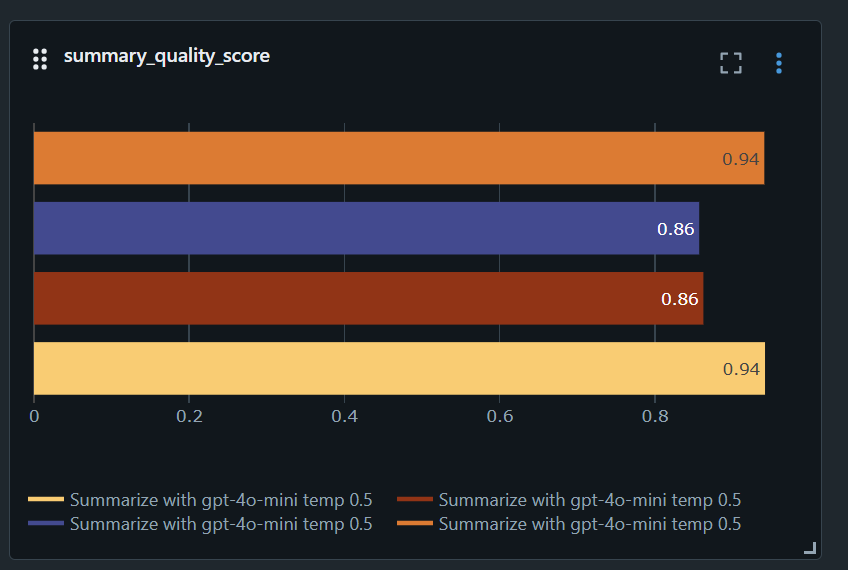